# ML Project - Tweet Success Model

This model uses a processed dataset that was previously treated and analysis in an EDA project. Raw dataset has been extracted from Twitter API.

The goal of this work is to create a classifying model to determine the degree of success (Low, Medium or High) of a tweet.

Steps will be as followed:

1. Load dataset <br />
2. Define target value
3. Features Transformation <br />
&nbsp;&nbsp;&nbsp; 3.1 Change of formats and slicing of ds <br />
&nbsp;&nbsp;&nbsp; 3.2 Create new features <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.1 Flag for exclamation mark in tweet <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2 Feature containing polarity of tweet <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2.1 Transformation of tweet for lexicon model <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.2.2 Lexicon model <br />
4. Pre-processing pipelines <br />
5. Models training  <br />
6. Final model selection



        
    

## Libraries

In [1]:
#Libraries and other main functions
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

## Loading data from EDA project

Data has been previously cleaned and explored during EDA project

In [2]:
tweets = pd.read_csv('../data/processed_files/tweets_total.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


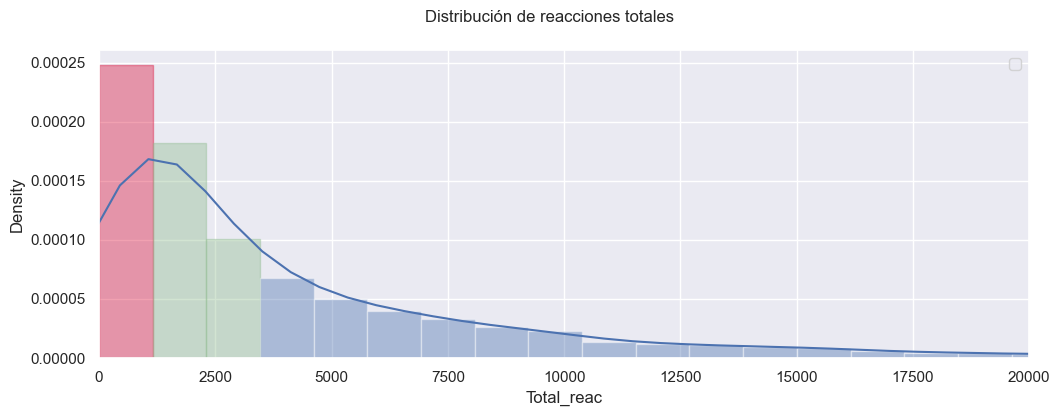

In [3]:
#Plot with target distribution
plt.figure(figsize=(12,4))
fig = sns.distplot(tweets['Total_reac'], bins=100)
fig.figure.suptitle("Distribución de reacciones totales", fontsize = 12)
plt.xlim(0, 20000)

heights = [p.get_height() for p in fig.patches]
first_highest = sorted(heights)[-1]
for p in fig.patches:
    if  p.get_height() >= first_highest:
        p.set_color('crimson')
        
heights = [p.get_height() for p in fig.patches]
second_highest = sorted(heights)[-2]
third_highest = sorted(heights)[-3]
for p in fig.patches:
    if  p.get_height() == second_highest or p.get_height() == third_highest:
        p.set_color('darkseagreen')

plt.legend();

### Define features of model

In [4]:
# read final dataframe to be used for classification model
df_model = pd.read_csv("../data/processed_files/tweets_final.csv")

#Features selection for classification model
df_features = df_model.drop(columns=['tweet', 'created_at','retweets', 'likes', 'id', 'entities', 'engage_rate', 'name', 'lang', 'hashtag_text', 'year','total_reac','categoria_tr'])

#Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(df_features, df_model.categoria_tr, test_size=0.2, random_state=42)

## Pre-processing pipelines

Pre-processing pipelines defined to scale numerical variables and labeling categorical ones

In [5]:
#Ordinal encoding for ordinal features
cat_pipeline = Pipeline(
    [("OrdinalEncoder", OrdinalEncoder()) #OE fot categorical ones
    ])

#Scaling for ordinal features
num_pipeline = Pipeline(
    [("SScaler", StandardScaler()) #Standarization for numerical values
    ])

#Pre-processing pipeline that combines scaling and labeling. This pipeline will later be used when training model
preprocessing = ColumnTransformer(
    [("Impute_Numeric", num_pipeline, ["followers","month", 'week_day', 'hour', 'tweet_len']),
     ("Process_Categorical", cat_pipeline, ["user","polarity"]),
    ], remainder = "passthrough")

## Classification models training

### Classification model selection

Four different models will be tested using GridSearchCV to optimize parameters based on accuracy metric.

Four models are: LightGBM, XGBoost, RandomForest and K-NN.

#### LightGBM

In [6]:
pipeline = Pipeline([
    ("preprocesado",preprocessing),
    ("lgbc",LGBMClassifier())
])

#definimos el espacio de parámetros a explorar
parameters = {
    'lgbc__min_data_in_leaf': (100,200,300),
    'lgbc__max_depth': (2,4,6,8,10)
}

grid_search_lgbm = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

grid_search_lgbm.fit(X_train, y_train)
print("Best acc:", grid_search_lgbm.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Best acc: 0.5864662655617361


**XGBoost**

In [7]:
pipeline = Pipeline([
    ("preprocesado",preprocessing),
    ("xgbc",XGBClassifier())
])

#definimos el espacio de parámetros a explorar
parameters = {
    'xgbc__learning_rate': [0.05, 0.1, 0.2, 0.4],
    'xgbc__max_depth': (2,4,6,8,10),
    "xgbc__n_estimators": [50, 100, 150, 200, 300, 500],
    'xgbc__random_state': [42]
}

grid_search_xgb = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

grid_search_xgb.fit(X_train, y_train)
print("Best acc:", grid_search_xgb.best_score_)

Best acc: 0.5810732962500473


**Random Forest**

In [8]:
pipeline = Pipeline([
    ("preprocesado",preprocessing),
    ("rfc",RandomForestClassifier()),
])

#definimos el espacio de parámetros a explorar
parameters = {
    'rfc__max_depth': (2,4,6,8,10),
    'rfc__max_features': (1,2,3,4,5,6,8,10),
    "rfc__n_estimators": [50, 100, 150],
}

grid_search_rfc = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

grid_search_rfc.fit(X_train, y_train)
print("Best acc:", grid_search_rfc.best_score_)

Best acc: 0.5913384039050971


**KNN**

In [9]:
pipeline = Pipeline([
    ("preprocesado",preprocessing),
    ("knn",KNeighborsClassifier()),
])

#definimos el espacio de parámetros a explorar
parameters = {
    'knn__n_neighbors': (6,8,10,100,150)
}

grid_search_knn = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

grid_search_knn.fit(X_train, y_train)
print("Best acc:", grid_search_knn.best_score_)

Best acc: 0.5478430393158511


## Final model selection

The two best performing models (LightGBM and Random Forest) will be analized against Test data in order to select final model. This analysis will be performed using a classification report & confusion matrix.

#### LightGBM

In [10]:
#Predict with LightGBM model and print confusion matrix
y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
print(classification_report(y_test,
                            y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58       416
           1       0.53      0.49      0.51       529
           2       0.65      0.69      0.67       492

    accuracy                           0.59      1437
   macro avg       0.58      0.59      0.58      1437
weighted avg       0.58      0.59      0.58      1437



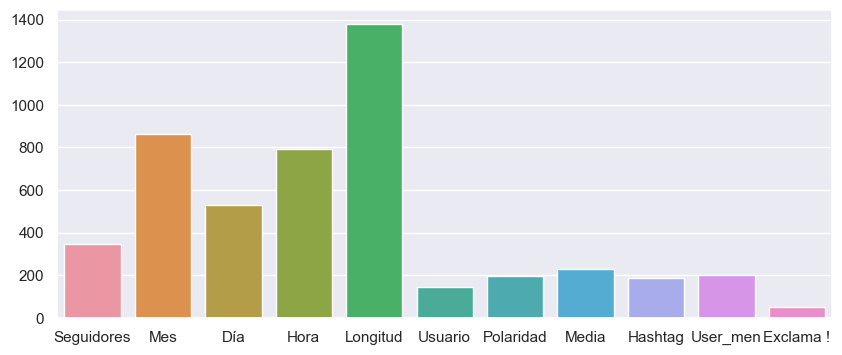

In [11]:
#Plot of the importance of each feature in the model that has been trained
columns= ["Seguidores","Mes", 'Día', 'Hora', 'Longitud', 'Usuario','Polaridad', 'Media', 'Hashtag', 'User_men', 'Exclama !']
plt.figure(figsize=(10,4))
fig = sns.barplot(x=columns, y=grid_search_lgbm.best_estimator_.named_steps["lgbc"].feature_importances_, width=0.8);

<AxesSubplot:>

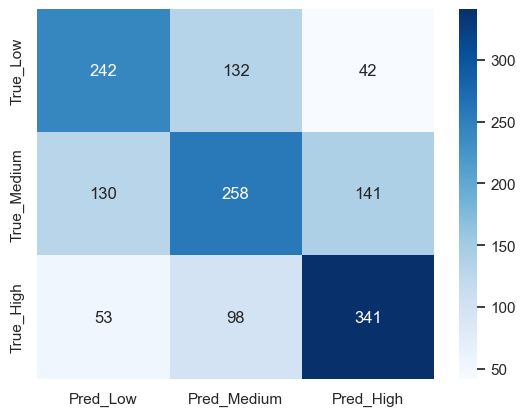

In [12]:
#Create confusion matrix and plot it with seaborn heatmap
c_matrix = confusion_matrix(y_test, y_pred_lgbm)

c_matrix_df = pd.DataFrame(c_matrix, 
                          columns=['Pred_Low', 'Pred_Medium', 'Pred_High'],
                          index=['True_Low', 'True_Medium', 'True_High'])
sns.heatmap(c_matrix_df, 
           annot=True,
           fmt='g',
           cmap="Blues")

#### RandomForest

In [13]:
#Predict with LightGBM model and print confusion matrix
y_pred_rfc = grid_search_rfc.best_estimator_.predict(X_test)
print(classification_report(y_test,
                            y_pred_rfc))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       416
           1       0.54      0.50      0.52       529
           2       0.66      0.72      0.69       492

    accuracy                           0.60      1437
   macro avg       0.60      0.60      0.60      1437
weighted avg       0.60      0.60      0.60      1437



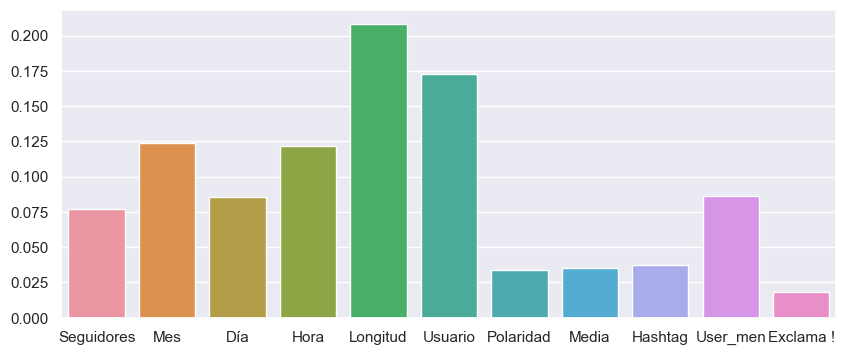

In [14]:
#Plot of the importance of each feature in the model that has been trained
columns= ["Seguidores","Mes", 'Día', 'Hora', 'Longitud', 'Usuario','Polaridad', 'Media', 'Hashtag', 'User_men', 'Exclama !']
plt.figure(figsize=(10,4))
fig = sns.barplot(x=columns, y=grid_search_rfc.best_estimator_.named_steps["rfc"].feature_importances_, width=0.8);

<AxesSubplot:>

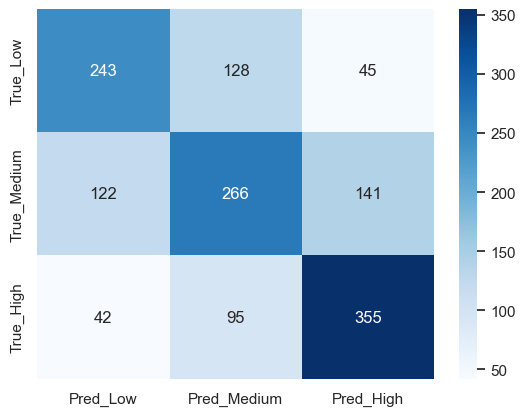

In [15]:
#Create confusion matrix and plot it with seaborn heatmap
c_matrix = confusion_matrix(y_test, y_pred_rfc)

c_matrix_df = pd.DataFrame(c_matrix, 
                          columns=['Pred_Low', 'Pred_Medium', 'Pred_High'],
                          index=['True_Low', 'True_Medium', 'True_High'])
sns.heatmap(c_matrix_df, 
           annot=True,
           fmt='g',
           cmap="Blues")